In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
%matplotlib inline
import cv2
import urllib.request
import json
from tqdm import tqdm
import requests
import warnings
warnings.filterwarnings('ignore')
from time import time
from matplotlib.colors import hsv_to_rgb
import colorsys

In [2]:
data = pd.read_csv('/content/drive/MyDrive/case_study_2/input/Sentiment_data.csv')

In [3]:
data.head(2)

,created_utc,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,text_words,processed_words,Text,url,upvote ratio,dank_level,Time_of_day,Sentiment,word_count,char_count
0,1.628380e+09,p040e9,0,https://i.redd.it/238mczwev0g71.jpg,0,1430077,114.0,https://b.thumbs.redditmedia.com/WBdc-Nus6faSe...,140.0,Invest in ye mudders credit card,167,Invest in ye mudders credit card {E || V] C ME...,"['invest', 'mudders', 'credit', 'card', 'meeti...",invest mudders credit card meetin purchase hsi...,/r/MemeEconomy/comments/p040e9/invest_in_ye_mu...,0.000117,0,5,0.45,10,101
1,1.628366e+09,p002qn,0,https://i.redd.it/4yacuh18qzf71.jpg,0,1430077,140.0,https://b.thumbs.redditmedia.com/avzbtegaypC3l...,140.0,Invest in bio-security,60,Invest in bio-security Mucch,"['invest', 'security', 'mucch']",invest security mucch,/r/MemeEconomy/comments/p002qn/invest_in_biose...,0.000042,0,4,0.50,3,28


In [4]:
from skimage import io
def url_to_cvimage(url):
    try:
        image = io.imread(url)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.waitKey(0)
    except:
        image =  np.array([None,None,None]) 
    return image

In [5]:
def cvimage_to_pic(cvimage):
    meme = cv2.cvtColor(cvimage, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(meme)
    plt.show()
    return meme

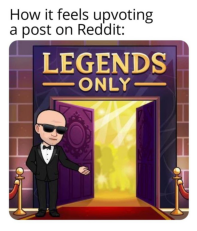

In [6]:
meme = cvimage_to_pic(url_to_cvimage(data.media.values[5150]))

In [7]:
# compute average h,s and v components
def average_hsv(meme):
    hsv_meme = cv2.cvtColor(meme, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_meme)
    return [h.mean(),s.mean(),v.mean()]

# check function
average_hsv(meme)

[73.05549260989676, 109.28021922063373, 144.6839454621838]

In [8]:
# compute average r g and b components
def average_rgb(meme):
    r, g, b = cv2.split(meme)
    return [r.mean(),g.mean(),b.mean()]

# check function
average_rgb(meme)

[140.49769321841862, 111.56604626293745, 107.05992412572724]

In [9]:
# colors in hsv
colors_to_mask = []
tan1 = (0, 45, 140)
tan2 = (30, 130, 250)
colors_to_mask.append([tan1,tan2])
light_orange = (1, 190, 200)
dark_orange = (18, 255, 255)
colors_to_mask.append([light_orange,dark_orange])

In [10]:
# function gets data about the amount of one color in image
def getColorMask(meme,color1,color2):
    hsv_meme = cv2.cvtColor(meme, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv_meme, color1, color2)
    result = cv2.bitwise_and(meme, meme, mask=mask)
    return (np.sum(mask)/(meme.shape[0]*meme.shape[1]))

# check
getColorMask(meme,tan1,tan2)

22.374463724204656

In [ ]:
# loop over rows of data frame and gather average r,g,b and h,s,v data
# do this in sections / copy this file and run multiple sections of data simultaneousnessly on different kernel
# takes ~7 minutes to run over 500 records
avg_hsv_list = []
avg_rgb_list = [] 
color_list = [[],[]]
for row in tqdm(range(0,data.shape[0])):
    x = data.iloc[row]
    url = x['media']
    meme = url_to_cvimage(url)
    try:
        avg_hsv_list.append(average_hsv(meme))
        avg_rgb_list.append(average_rgb(meme))
        for i in range(0,len(colors_to_mask)):
            color_list[i].append(getColorMask(meme,colors_to_mask[i][0],colors_to_mask[i][1]))
    except:  
        avg_hsv_list.append([None,None,None])
        avg_rgb_list.append([None,None,None])
        color_list[0].append(None)
        color_list[1].append(None)
        continue       

100%|██████████| 30000/30000 [1:26:28<00:00,  5.78it/s]


In [ ]:
# add attributes to data frame
data['avg_hue'] = [row[0] for row in avg_hsv_list]
data['avg_saturation'] = [row[1] for row in avg_hsv_list]
data['avg_value'] = [row[2] for row in avg_hsv_list]
data['avg_redRGB'] = [row[0] for row in avg_rgb_list]
data['avg_greenRGB'] = [row[1] for row in avg_rgb_list]
data['avg_blueRGB'] = [row[2] for row in avg_rgb_list]
data['avg_tan'] = color_list[0]
data['avg_orange'] = color_list[1]

In [ ]:
data.head(2)

,created_utc,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,text_words,processed_words,Text,url,upvote ratio,dank_level,Time_of_day,Sentiment,word_count,char_count,avg_hue,avg_saturation,avg_value,avg_redRGB,avg_greenRGB,avg_blueRGB,avg_tan,avg_orange
0,1.628380e+09,p040e9,0,https://i.redd.it/238mczwev0g71.jpg,0,1430077,114.0,https://b.thumbs.redditmedia.com/WBdc-Nus6faSe...,140.0,Invest in ye mudders credit card,167,Invest in ye mudders credit card {E || V] C ME...,"['invest', 'mudders', 'credit', 'card', 'meeti...",invest mudders credit card meetin purchase hsi...,/r/MemeEconomy/comments/p040e9/invest_in_ye_mu...,0.000117,0,5,0.45,10,101,46.715343,115.816747,173.073604,159.565135,119.666843,111.009154,119.731336,0.0
1,1.628366e+09,p002qn,0,https://i.redd.it/4yacuh18qzf71.jpg,0,1430077,140.0,https://b.thumbs.redditmedia.com/avzbtegaypC3l...,140.0,Invest in bio-security,60,Invest in bio-security Mucch,"['invest', 'security', 'mucch']",invest security mucch,/r/MemeEconomy/comments/p002qn/invest_in_biose...,0.000042,0,4,0.50,3,28,64.133123,88.576772,135.897159,124.226934,113.670314,110.440120,1.147583,0.0


In [ ]:
data.to_csv('/content/drive/MyDrive/case_study_2/input/data_8.csv',index=False)

In [11]:
data = pd.read_csv('/content/drive/MyDrive/case_study_2/input/data_8.csv')

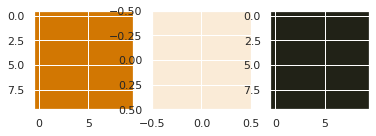

In [11]:
# functions to convert an rgb color to a range in hsv that can be used to mask the images
def rgb_hsv_converter(rgb):
    (r,g,b) = rgb_normalizer(rgb)
    hsv = colorsys.rgb_to_hsv(r,g,b)
    (h,s,v) = hsv_normalizer(hsv)
    upper_band = [h+10, s+40, v+40] 
    lower_band = [h-10, s-40, v-40]                     
    return {
        'upper_band': upper_band,
        'lower_band': lower_band
    }

def rgb_normalizer(rgb):
    (r,g,b) = rgb
    return (r/255, g/255, b/255)

def hsv_normalizer(hsv):
    (h,s,v) = hsv
    return (h*360, s*255, v*255)

# display range of colors to check functions
rgb = (250,235,215) # green: (128, 255, 0)
dict_colors = rgb_hsv_converter(rgb)

color_2 = tuple(dict_colors['lower_band'])
color_1 = tuple(dict_colors['upper_band'])

do_square = np.full((10, 10, 3), color_2, dtype=np.uint8) / 255.0
lo_square = np.full((10, 10, 3), color_1, dtype=np.uint8) / 255.0

plt.subplot(1, 3, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 3, 2)
plt.imshow([[rgb]]) 
plt.subplot(1, 3, 3)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

In [12]:
# define the rgb colors to extract from memes

rgb_colors = [(250,235,215),
              (127,255,212),
              (227,207,87),
              (0,0,0),
              (138,43,226),
              (165,42,42),
              (139,115,85),
              (83,134,139),
              (255,97,3),
              (255,127,80),
              (0,100,0),
              (255,20,147),
              (248,248,255),
              (173,255,47),
              (255,255,0)
             ]
colr_dict = { 'off-white': [],
              'aqua': [],
              'mustard': [],
              'black': [],
              'purple': [],
              'red-brown': [],
              'dust-brown': [],
              'gray-blue': [],
              'orange': [],
              'salmon': [],
              'dark-green': [],
              'pink': [],
              'white': [],
              'yellow-green': [],
              'bright-yellow': []
            }

In [ ]:
t0 = time()
for i in tqdm(range(0,len(data))): 
    try:
        url = data.iloc[i]['media']
        im = url_to_cvimage(url)
        meme = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        counter = 0
        for key in colr_dict:
            dict_colors = rgb_hsv_converter(rgb_colors[counter])
            color_2 = tuple(dict_colors['lower_band'])
            color_1 = tuple(dict_colors['upper_band'])
            colr_dict[key].append(getColorMask(meme,color_2,color_1))
            counter += 1
    except:
        for key in colr_dict:
            colr_dict[key].append(None)
        print("Fail")
t1 = time()   
print('seconds to run: %f' %(t1-t0))

In [16]:
for key in colr_dict:
    data[key] = colr_dict[key]
# save new data frame to json file
data.to_json(r'/content/drive/MyDrive/case_study_2/input/dank_cleaned.json')


In [17]:
data.head()

,created_utc,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,text_words,processed_words,Text,url,upvote ratio,dank_level,Time_of_day,Sentiment,word_count,char_count,avg_hue,avg_saturation,avg_value,avg_redRGB,avg_greenRGB,avg_blueRGB,avg_tan,avg_orange,off-white,aqua,mustard,black,purple,red-brown,dust-brown,gray-blue,orange,salmon,dark-green,pink,white,yellow-green,bright-yellow
0,1.628380e+09,p040e9,0,https://i.redd.it/238mczwev0g71.jpg,0,1430077,114.0,https://b.thumbs.redditmedia.com/WBdc-Nus6faSe...,140.0,Invest in ye mudders credit card,167,Invest in ye mudders credit card {E || V] C ME...,"['invest', 'mudders', 'credit', 'card', 'meeti...",invest mudders credit card meetin purchase hsi...,/r/MemeEconomy/comments/p040e9/invest_in_ye_mu...,0.000117,0,5,0.45,10,101,46.715343,115.816747,173.073604,159.565135,119.666843,111.009154,119.731336,0.0,0.141470,0.009757,0.0,0.024391,0.0,0.825039,0.096549,0.071345,0.013415,1.887489,0.760605,0.0,0.0,0.234767,0.0
1,1.628366e+09,p002qn,0,https://i.redd.it/4yacuh18qzf71.jpg,0,1430077,140.0,https://b.thumbs.redditmedia.com/avzbtegaypC3l...,140.0,Invest in bio-security,60,Invest in bio-security Mucch,"['invest', 'security', 'mucch']",invest security mucch,/r/MemeEconomy/comments/p002qn/invest_in_biose...,0.000042,0,4,0.50,3,28,64.133123,88.576772,135.897159,124.226934,113.670314,110.440120,1.147583,0.0,3.154712,0.000208,0.0,0.439941,0.0,0.026562,0.059351,0.068896,0.000623,0.055823,39.820715,0.0,0.0,0.000000,0.0
2,1.628364e+09,ozzmum,0,https://i.redd.it/fkqta3ctlzf71.jpg,0,1430077,140.0,default,140.0,INVEST in Jontron slicing the price in half! A...,15,INVEST in Jontron slicing the price in half! A...,"['invest', 'jontron', 'slice', 'price', 'half'...",invest jontron slice price half bargain sure g...,/r/MemeEconomy/comments/ozzmum/invest_in_jontr...,0.000010,0,4,0.51,13,135,93.662060,62.428856,130.200325,114.445672,105.270329,117.187462,17.447007,0.0,0.094066,0.000000,0.0,4.056133,0.0,0.224274,0.028004,3.597819,0.000000,0.593357,0.000000,0.0,0.0,0.000000,0.0
3,1.628357e+09,ozxfph,0,https://i.redd.it/xv0li2430zf71.png,0,1430077,140.0,https://b.thumbs.redditmedia.com/2GQTtYFKN3Om9...,140.0,Invest in Elmo in Vietnam,26,Invest in Elmo in Vietnam,"['invest', 'elmo', 'vietnam']",invest elmo vietnam,/r/MemeEconomy/comments/ozxfph/invest_in_elmo_...,0.000018,0,4,0.50,3,26,19.343506,40.170647,35.248237,16.409659,16.465027,35.248237,0.000000,0.0,0.015111,0.000000,0.0,176.462519,0.0,0.141037,0.000000,0.030222,0.000000,0.065481,0.000000,0.0,0.0,0.000000,0.0
4,1.628355e+09,ozwwz7,0,https://i.redd.it/n4ouph71vyf71.jpg,0,1430077,140.0,default,140.0,Invest in woman with her statue,23,Invest in woman with her statue,"['invest', 'woman', 'statue']",invest woman statue,/r/MemeEconomy/comments/ozwwz7/invest_in_woman...,0.000016,0,3,0.49,3,32,35.058768,43.135258,137.853427,135.663968,131.371310,121.080027,30.750222,0.0,1.416236,0.000000,0.0,0.486460,0.0,0.000000,0.142843,0.011545,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [13]:
data = pd.read_json('/content/drive/MyDrive/case_study_2/input/dank_cleaned.json')

In [14]:

more_colors = [(60,179,113),
               (30,144,255),
               (221,160,221),
               (139,69,19),
               (199,21,133),
               (72,61,139),
               (25,25,112),
               (95,158,160),
               (0,250,154),
               (128,128,0),
               (255,99,71),
               (34,139,34),
               (232,91,31),
               (206,166,149)
              ]
more_colDic = { 'medium_sea_green': [],
               'dodgerblue': [],
               'plum': [],
               'saddlebrown': [],
               'medium_violet_red': [],
               'dark_slate_blue': [],
               'midnight_blue': [],
               'cadet_blue': [],
               'medium_spring_green': [],
               'olive': [],
               'tomato': [],
               'forestgreen': [],
               'thick_pink'
               'desaturated_orange':[]
              }

In [15]:
t0 = time()
for i in tqdm(range(0,len(data))): 
    try:
        url = data.iloc[i]['media']
        im = url_to_cvimage(url)
        meme = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        counter = 0
        for key in more_colDic:
            dict_colors = rgb_hsv_converter(more_colors[counter])
            color_2 = tuple(dict_colors['lower_band'])
            color_1 = tuple(dict_colors['upper_band'])
            more_colDic[key].append(getColorMask(meme,color_2,color_1))
            counter += 1
    except:
        for key in more_colDic:
             more_colDic[key].append(None)
        print("Fail")
t1 = time()   
print('seconds to run: %f' %(t1-t0))
more_colDic

  0%|          | 19/30000 [00:05<1:07:26,  7.41it/s]

Fail


  0%|          | 34/30000 [00:09<1:58:40,  4.21it/s]

Fail


  0%|          | 63/30000 [00:13<1:04:04,  7.79it/s]

Fail


  1%|          | 237/30000 [00:43<1:04:35,  7.68it/s]

Fail


  1%|          | 263/30000 [00:49<1:26:34,  5.73it/s]

Fail


  1%|          | 344/30000 [01:04<1:30:22,  5.47it/s]

Fail


  1%|          | 363/30000 [01:07<1:03:16,  7.81it/s]

Fail


  1%|▏         | 432/30000 [01:21<51:04,  9.65it/s]

Fail


  2%|▏         | 500/30000 [01:33<59:13,  8.30it/s]  

Fail


  2%|▏         | 519/30000 [01:37<1:13:16,  6.70it/s]

Fail


  2%|▏         | 525/30000 [01:37<1:07:56,  7.23it/s]

Fail


  2%|▏         | 564/30000 [01:46<1:29:18,  5.49it/s]

Fail


  2%|▏         | 590/30000 [01:50<1:15:36,  6.48it/s]

Fail


  2%|▏         | 634/30000 [01:57<1:12:20,  6.77it/s]

Fail


  2%|▏         | 715/30000 [02:10<1:03:28,  7.69it/s]

Fail


  2%|▏         | 726/30000 [02:12<55:52,  8.73it/s]  

Fail


  3%|▎         | 815/30000 [02:26<1:00:42,  8.01it/s]

Fail


  3%|▎         | 866/30000 [02:38<1:06:33,  7.29it/s]

Fail


  3%|▎         | 937/30000 [02:48<57:04,  8.49it/s]  

Fail


  3%|▎         | 1026/30000 [03:06<1:36:24,  5.01it/s]

Fail


  4%|▎         | 1102/30000 [03:17<49:29,  9.73it/s]

Fail


  4%|▎         | 1120/30000 [03:20<1:08:06,  7.07it/s]

Fail


  4%|▍         | 1164/30000 [03:26<1:15:23,  6.38it/s]

Fail


  4%|▍         | 1271/30000 [03:43<59:23,  8.06it/s]  

Fail


  5%|▍         | 1429/30000 [04:12<57:44,  8.25it/s]  

Fail


  5%|▍         | 1472/30000 [04:20<1:15:55,  6.26it/s]

Fail


  5%|▌         | 1535/30000 [04:30<50:35,  9.38it/s]

Fail


  5%|▌         | 1637/30000 [04:46<1:20:06,  5.90it/s]

Fail


  6%|▌         | 1660/30000 [04:49<1:16:22,  6.18it/s]

Fail


  6%|▌         | 1745/30000 [05:02<1:06:58,  7.03it/s]

Fail


  6%|▋         | 1920/30000 [05:28<1:00:59,  7.67it/s]

Fail


  7%|▋         | 1969/30000 [05:36<43:55, 10.64it/s]

Fail


  7%|▋         | 1994/30000 [05:39<1:01:11,  7.63it/s]

Fail


  7%|▋         | 2003/30000 [05:40<43:00, 10.85it/s]

Fail


  7%|▋         | 2028/30000 [05:45<1:10:15,  6.64it/s]

Fail


  7%|▋         | 2150/30000 [06:05<43:11, 10.75it/s]

Fail


  7%|▋         | 2201/30000 [06:13<1:01:57,  7.48it/s]

Fail


  7%|▋         | 2213/30000 [06:15<1:08:04,  6.80it/s]

Fail


  8%|▊         | 2259/30000 [06:23<54:58,  8.41it/s]

Fail


  8%|▊         | 2310/30000 [06:37<1:24:17,  5.48it/s]

Fail


  8%|▊         | 2318/30000 [06:39<1:11:52,  6.42it/s]

Fail


  8%|▊         | 2352/30000 [06:43<1:03:40,  7.24it/s]

Fail


  8%|▊         | 2394/30000 [06:51<1:03:25,  7.25it/s]

Fail


  8%|▊         | 2468/30000 [07:03<1:03:18,  7.25it/s]

Fail
Fail


  8%|▊         | 2490/30000 [07:08<1:09:58,  6.55it/s]

Fail


  8%|▊         | 2521/30000 [07:13<1:06:09,  6.92it/s]

Fail


  9%|▉         | 2716/30000 [07:47<48:04,  9.46it/s]

Fail


  9%|▉         | 2782/30000 [07:58<1:02:51,  7.22it/s]

Fail


  9%|▉         | 2844/30000 [08:07<1:02:49,  7.20it/s]

Fail


 10%|▉         | 2986/30000 [08:28<1:12:24,  6.22it/s]

Fail


 10%|█         | 3012/30000 [08:32<1:02:23,  7.21it/s]

Fail


 10%|█         | 3080/30000 [08:42<57:23,  7.82it/s]

Fail


 10%|█         | 3102/30000 [08:45<46:32,  9.63it/s]

Fail


 10%|█         | 3147/30000 [08:53<52:02,  8.60it/s]

Fail


 11%|█         | 3183/30000 [08:59<50:20,  8.88it/s]

Fail


 11%|█         | 3233/30000 [09:06<50:27,  8.84it/s]

Fail


 12%|█▏        | 3530/30000 [10:03<1:14:00,  5.96it/s]

Fail


 12%|█▏        | 3537/30000 [10:05<1:06:30,  6.63it/s]

Fail


 12%|█▏        | 3674/30000 [10:27<57:49,  7.59it/s]

Fail


 13%|█▎        | 3770/30000 [10:43<1:38:45,  4.43it/s]

Fail


 13%|█▎        | 3779/30000 [10:44<57:29,  7.60it/s]

Fail


 13%|█▎        | 3916/30000 [11:12<1:03:27,  6.85it/s]

Fail


 14%|█▍        | 4145/30000 [11:51<56:28,  7.63it/s]

Fail


 14%|█▍        | 4189/30000 [11:56<1:03:00,  6.83it/s]

Fail


 14%|█▍        | 4202/30000 [11:58<52:42,  8.16it/s]

Fail


 14%|█▍        | 4284/30000 [12:12<2:02:49,  3.49it/s]

Fail


 14%|█▍        | 4297/30000 [12:14<1:00:40,  7.06it/s]

Fail


 15%|█▌        | 4586/30000 [13:03<1:40:23,  4.22it/s]

Fail


 15%|█▌        | 4635/30000 [13:11<55:51,  7.57it/s]  

Fail


 16%|█▌        | 4694/30000 [13:19<46:44,  9.02it/s]

Fail


 16%|█▋        | 4901/30000 [13:56<55:25,  7.55it/s]

Fail


 17%|█▋        | 5013/30000 [14:16<1:02:11,  6.70it/s]

Fail


 17%|█▋        | 5151/30000 [14:38<44:23,  9.33it/s]

Fail


 18%|█▊        | 5281/30000 [15:03<1:14:03,  5.56it/s]

Fail


 18%|█▊        | 5299/30000 [15:07<1:09:29,  5.92it/s]

Fail


 18%|█▊        | 5428/30000 [15:27<42:39,  9.60it/s]

Fail


 18%|█▊        | 5440/30000 [15:28<51:59,  7.87it/s]

Fail


 18%|█▊        | 5513/30000 [15:39<57:37,  7.08it/s]  

Fail


 19%|█▊        | 5613/30000 [15:55<59:31,  6.83it/s]  

Fail


 19%|█▉        | 5645/30000 [15:59<1:02:31,  6.49it/s]

Fail


 19%|█▉        | 5671/30000 [16:04<1:17:21,  5.24it/s]

Fail


 19%|█▉        | 5797/30000 [16:22<43:11,  9.34it/s]

Fail


 20%|█▉        | 5898/30000 [16:36<45:45,  8.78it/s]

Fail


 20%|█▉        | 5961/30000 [16:46<42:47,  9.36it/s]

Fail
Fail


 20%|██        | 6053/30000 [16:58<38:06, 10.47it/s]

Fail


 20%|██        | 6100/30000 [17:06<55:35,  7.17it/s]

Fail


 21%|██        | 6177/30000 [17:20<51:37,  7.69it/s]

Fail


 21%|██        | 6236/30000 [17:30<51:47,  7.65it/s]

Fail
Fail


 21%|██        | 6250/30000 [17:39<6:44:55,  1.02s/it] 

Fail


 21%|██        | 6362/30000 [17:57<1:22:11,  4.79it/s]

Fail


 21%|██▏       | 6441/30000 [18:11<46:20,  8.47it/s]

Fail


 22%|██▏       | 6469/30000 [18:15<52:17,  7.50it/s]  

Fail


 22%|██▏       | 6484/30000 [18:18<53:29,  7.33it/s]  

Fail


 22%|██▏       | 6555/30000 [18:29<1:08:08,  5.74it/s]

Fail


 22%|██▏       | 6597/30000 [18:37<1:17:16,  5.05it/s]

Fail


 22%|██▏       | 6738/30000 [19:01<1:10:43,  5.48it/s]

Fail


 23%|██▎       | 6816/30000 [19:15<54:18,  7.12it/s]

Fail


 23%|██▎       | 6882/30000 [19:28<49:04,  7.85it/s]

Fail


 23%|██▎       | 6887/30000 [19:29<1:13:19,  5.25it/s]

Fail


 23%|██▎       | 6908/30000 [19:33<48:31,  7.93it/s]

Fail


 23%|██▎       | 6996/30000 [19:51<1:09:46,  5.49it/s]

Fail


 23%|██▎       | 7002/30000 [19:52<56:20,  6.80it/s]  

Fail


 23%|██▎       | 7009/30000 [19:54<57:58,  6.61it/s]  

Fail


 23%|██▎       | 7049/30000 [20:01<2:02:33,  3.12it/s]

Fail


 24%|██▎       | 7053/30000 [20:01<1:13:16,  5.22it/s]

Fail


 24%|██▎       | 7072/30000 [20:05<1:00:58,  6.27it/s]

Fail


 24%|██▎       | 7087/30000 [20:07<39:52,  9.58it/s]

Fail


 24%|██▎       | 7104/30000 [20:10<1:17:38,  4.91it/s]

Fail


 24%|██▍       | 7195/30000 [20:31<1:29:35,  4.24it/s]

Fail


 24%|██▍       | 7260/30000 [20:40<52:32,  7.21it/s]

Fail


 25%|██▍       | 7377/30000 [21:01<47:05,  8.01it/s]

Fail


 25%|██▍       | 7416/30000 [21:08<52:26,  7.18it/s]

Fail


 25%|██▍       | 7431/30000 [21:10<45:56,  8.19it/s]

Fail


 25%|██▍       | 7440/30000 [21:11<41:45,  9.00it/s]

Fail


 25%|██▍       | 7458/30000 [21:14<1:00:26,  6.22it/s]

Fail


 25%|██▍       | 7466/30000 [21:16<51:07,  7.35it/s]

Fail


 25%|██▍       | 7476/30000 [21:18<1:41:04,  3.71it/s]

Fail


 25%|██▍       | 7483/30000 [21:19<59:28,  6.31it/s]  

Fail


 25%|██▍       | 7491/30000 [21:21<55:29,  6.76it/s]  

Fail


 25%|██▌       | 7553/30000 [21:32<45:08,  8.29it/s]

Fail


 25%|██▌       | 7556/30000 [21:32<52:37,  7.11it/s]

Fail


 25%|██▌       | 7597/30000 [21:40<55:54,  6.68it/s]  

Fail


 26%|██▋       | 7892/30000 [22:35<48:21,  7.62it/s]

Fail


 26%|██▋       | 7942/30000 [22:44<1:06:04,  5.56it/s]

Fail


 27%|██▋       | 8008/30000 [22:55<50:27,  7.27it/s]

Fail


 27%|██▋       | 8014/30000 [22:55<49:14,  7.44it/s]

Fail


 27%|██▋       | 8019/30000 [22:56<44:28,  8.24it/s]

Fail


 27%|██▋       | 8029/30000 [22:58<52:59,  6.91it/s]

Fail


 27%|██▋       | 8045/30000 [23:00<49:02,  7.46it/s]

Fail


 27%|██▋       | 8076/30000 [23:04<51:41,  7.07it/s]

Fail


 27%|██▋       | 8093/30000 [23:06<44:46,  8.15it/s]

Fail


 27%|██▋       | 8205/30000 [23:27<51:32,  7.05it/s]

Fail


 27%|██▋       | 8209/30000 [23:27<52:10,  6.96it/s]

Fail


 27%|██▋       | 8247/30000 [23:33<55:27,  6.54it/s]

Fail


 28%|██▊       | 8268/30000 [23:36<53:23,  6.78it/s]

Fail


 28%|██▊       | 8311/30000 [23:43<43:41,  8.27it/s]

Fail


 28%|██▊       | 8355/30000 [23:51<43:40,  8.26it/s]

Fail


 28%|██▊       | 8391/30000 [23:56<39:32,  9.11it/s]

Fail


 28%|██▊       | 8409/30000 [24:00<1:04:43,  5.56it/s]

Fail


 28%|██▊       | 8460/30000 [24:08<48:49,  7.35it/s]  

Fail


 29%|██▊       | 8574/30000 [24:29<1:47:27,  3.32it/s]

Fail


 29%|██▊       | 8579/30000 [24:30<58:07,  6.14it/s]

Fail


 29%|██▉       | 8633/30000 [24:40<1:15:16,  4.73it/s]

Fail


 29%|██▉       | 8738/30000 [24:57<45:16,  7.83it/s]

Fail


 29%|██▉       | 8832/30000 [25:14<42:15,  8.35it/s]

Fail


 29%|██▉       | 8847/30000 [25:18<55:05,  6.40it/s]

Fail


 29%|██▉       | 8848/30000 [25:18<51:04,  6.90it/s]

Fail


 30%|██▉       | 8948/30000 [25:34<46:15,  7.59it/s]

Fail


 30%|██▉       | 8971/30000 [25:37<39:01,  8.98it/s]

Fail


 30%|███       | 9090/30000 [25:55<49:48,  7.00it/s]

Fail


 30%|███       | 9104/30000 [25:58<52:48,  6.59it/s]

Fail


 30%|███       | 9105/30000 [25:58<48:51,  7.13it/s]

Fail


 31%|███       | 9183/30000 [26:12<40:51,  8.49it/s]

Fail


 31%|███       | 9210/30000 [26:18<40:56,  8.46it/s]

Fail


 31%|███       | 9256/30000 [26:26<43:30,  7.95it/s]

Fail


 31%|███▏      | 9422/30000 [26:53<53:09,  6.45it/s]

Fail


 31%|███▏      | 9444/30000 [26:56<37:50,  9.05it/s]

Fail


 32%|███▏      | 9619/30000 [27:25<45:11,  7.52it/s]

Fail


 33%|███▎      | 9843/30000 [27:57<47:13,  7.11it/s]

Fail


 33%|███▎      | 9973/30000 [28:20<50:21,  6.63it/s]

Fail


 34%|███▍      | 10188/30000 [28:52<47:45,  6.91it/s]

Fail


 34%|███▍      | 10282/30000 [29:09<38:21,  8.57it/s]

Fail


 35%|███▍      | 10478/30000 [29:42<39:15,  8.29it/s]

Fail


 35%|███▌      | 10626/30000 [30:08<37:32,  8.60it/s]

Fail


 36%|███▌      | 10698/30000 [30:19<40:17,  7.98it/s]

Fail


 36%|███▌      | 10725/30000 [30:23<45:36,  7.04it/s]

Fail


 36%|███▌      | 10737/30000 [30:24<38:58,  8.24it/s]

Fail


 36%|███▌      | 10744/30000 [30:25<44:18,  7.24it/s]

Fail


 36%|███▌      | 10808/30000 [30:35<39:26,  8.11it/s]

Fail


 36%|███▋      | 10880/30000 [30:48<1:11:31,  4.45it/s]

Fail


 36%|███▋      | 10934/30000 [31:01<40:16,  7.89it/s]

Fail


 37%|███▋      | 10991/30000 [31:11<44:29,  7.12it/s]

Fail


 37%|███▋      | 11045/30000 [31:18<39:47,  7.94it/s]

Fail


 37%|███▋      | 11062/30000 [31:21<42:00,  7.51it/s]

Fail


 37%|███▋      | 11225/30000 [31:49<48:51,  6.40it/s]

Fail


 38%|███▊      | 11326/30000 [32:04<40:40,  7.65it/s]

Fail


 38%|███▊      | 11447/30000 [32:24<44:12,  6.99it/s]

Fail


 38%|███▊      | 11467/30000 [32:28<50:12,  6.15it/s]

Fail


 39%|███▉      | 11628/30000 [32:57<42:27,  7.21it/s]

Fail


 39%|███▉      | 11642/30000 [33:00<36:09,  8.46it/s]

Fail


 40%|███▉      | 11886/30000 [33:46<39:17,  7.68it/s]

Fail


 40%|███▉      | 11896/30000 [33:49<54:56,  5.49it/s]

Fail


 40%|████      | 12012/30000 [34:06<34:53,  8.59it/s]

Fail


 41%|████      | 12286/30000 [34:51<36:59,  7.98it/s]

Fail


 42%|████▏     | 12481/30000 [35:22<30:43,  9.51it/s]

Fail


 42%|████▏     | 12564/30000 [35:35<29:50,  9.74it/s]

Fail


 42%|████▏     | 12575/30000 [35:37<39:22,  7.38it/s]

Fail


 42%|████▏     | 12621/30000 [35:47<39:12,  7.39it/s]

Fail


 42%|████▏     | 12687/30000 [35:57<53:39,  5.38it/s]  

Fail


 42%|████▏     | 12703/30000 [36:01<52:05,  5.53it/s]

Fail


 42%|████▏     | 12744/30000 [36:08<34:13,  8.40it/s]

Fail


 43%|████▎     | 12937/30000 [36:38<34:32,  8.23it/s]

Fail


 44%|████▎     | 13060/30000 [37:00<36:06,  7.82it/s]

Fail


 44%|████▍     | 13169/30000 [37:26<49:47,  5.63it/s]

Fail


 44%|████▍     | 13254/30000 [37:40<43:46,  6.37it/s]

Fail


 44%|████▍     | 13286/30000 [37:44<32:05,  8.68it/s]

Fail


 45%|████▍     | 13362/30000 [37:56<34:06,  8.13it/s]

Fail


 45%|████▍     | 13401/30000 [38:04<40:19,  6.86it/s]

Fail


 45%|████▌     | 13528/30000 [38:28<45:58,  5.97it/s]

Fail


 45%|████▌     | 13547/30000 [38:32<42:03,  6.52it/s]

Fail


 45%|████▌     | 13628/30000 [38:48<39:24,  6.93it/s]

Fail


 46%|████▌     | 13848/30000 [39:22<32:24,  8.31it/s]

Fail


 46%|████▌     | 13866/30000 [39:25<37:04,  7.25it/s]

Fail


 47%|████▋     | 13997/30000 [39:47<30:35,  8.72it/s]

Fail


 47%|████▋     | 14010/30000 [39:49<31:59,  8.33it/s]

Fail


 47%|████▋     | 14037/30000 [39:55<44:24,  5.99it/s]

Fail


 47%|████▋     | 14041/30000 [39:55<33:22,  7.97it/s]

Fail


 47%|████▋     | 14138/30000 [40:10<48:32,  5.45it/s]

Fail


 47%|████▋     | 14184/30000 [40:18<52:47,  4.99it/s]  

Fail


 48%|████▊     | 14290/30000 [40:34<32:03,  8.17it/s]

Fail


 48%|████▊     | 14353/30000 [40:47<33:13,  7.85it/s]

Fail


 48%|████▊     | 14361/30000 [40:48<42:47,  6.09it/s]

Fail


 49%|████▉     | 14735/30000 [41:56<46:35,  5.46it/s]

Fail


 49%|████▉     | 14770/30000 [42:01<49:23,  5.14it/s]  

Fail


 49%|████▉     | 14796/30000 [42:07<35:24,  7.16it/s]

Fail


 50%|████▉     | 14965/30000 [42:35<1:22:39,  3.03it/s]

Fail


 50%|████▉     | 14982/30000 [42:37<26:05,  9.59it/s]

Fail


 51%|█████     | 15212/30000 [43:17<28:58,  8.50it/s]

Fail


 51%|█████     | 15270/30000 [43:24<26:53,  9.13it/s]

Fail


 51%|█████▏    | 15402/30000 [43:47<43:41,  5.57it/s]

Fail
Fail


 51%|█████▏    | 15422/30000 [43:50<34:13,  7.10it/s]

Fail


 52%|█████▏    | 15526/30000 [44:06<28:45,  8.39it/s]

Fail


 52%|█████▏    | 15743/30000 [44:42<27:21,  8.68it/s]

Fail


 53%|█████▎    | 15813/30000 [44:53<47:01,  5.03it/s]  

Fail


 53%|█████▎    | 15909/30000 [45:13<36:43,  6.40it/s]

Fail


 53%|█████▎    | 15923/30000 [45:18<59:10,  3.96it/s]  

Fail


 53%|█████▎    | 16011/30000 [45:31<25:59,  8.97it/s]

Fail


 53%|█████▎    | 16023/30000 [45:33<43:01,  5.41it/s]

Fail


 54%|█████▎    | 16098/30000 [45:46<35:02,  6.61it/s]

Fail


 54%|█████▎    | 16111/30000 [45:48<30:29,  7.59it/s]

Fail


 54%|█████▍    | 16163/30000 [45:54<27:12,  8.48it/s]

Fail


 54%|█████▍    | 16254/30000 [46:11<31:00,  7.39it/s]

Fail


 56%|█████▌    | 16725/30000 [47:31<33:23,  6.63it/s]

Fail


 56%|█████▌    | 16730/30000 [47:32<27:37,  8.00it/s]

Fail


 56%|█████▋    | 16928/30000 [48:09<39:55,  5.46it/s]

Fail


 56%|█████▋    | 16933/30000 [48:10<27:20,  7.97it/s]

Fail


 57%|█████▋    | 17046/30000 [48:29<25:50,  8.36it/s]

Fail


 57%|█████▋    | 17107/30000 [48:39<47:40,  4.51it/s]

Fail


 57%|█████▋    | 17216/30000 [48:56<22:54,  9.30it/s]

Fail


 58%|█████▊    | 17257/30000 [49:06<58:48,  3.61it/s]  

Fail
Fail


 58%|█████▊    | 17495/30000 [49:41<25:15,  8.25it/s]

Fail


 58%|█████▊    | 17517/30000 [49:46<30:30,  6.82it/s]

Fail


 58%|█████▊    | 17525/30000 [49:47<31:08,  6.68it/s]

Fail


 59%|█████▊    | 17562/30000 [49:52<24:53,  8.33it/s]

Fail


 59%|█████▊    | 17596/30000 [49:57<23:07,  8.94it/s]

Fail


 59%|█████▊    | 17612/30000 [50:00<23:04,  8.95it/s]

Fail
Fail


 59%|█████▉    | 17625/30000 [50:02<26:59,  7.64it/s]

Fail


 59%|█████▉    | 17646/30000 [50:05<20:10, 10.20it/s]

Fail


 59%|█████▉    | 17648/30000 [50:05<19:58, 10.30it/s]

Fail


 59%|█████▉    | 17654/30000 [50:05<18:46, 10.96it/s]

Fail


 59%|█████▉    | 17667/30000 [50:08<34:05,  6.03it/s]

Fail


 59%|█████▉    | 17701/30000 [50:13<29:56,  6.85it/s]

Fail


 59%|█████▉    | 17717/30000 [50:17<36:52,  5.55it/s]

Fail


 59%|█████▉    | 17726/30000 [50:19<30:14,  6.76it/s]

Fail


 59%|█████▉    | 17729/30000 [50:19<21:37,  9.46it/s]

Fail


 59%|█████▉    | 17733/30000 [50:19<26:26,  7.73it/s]

Fail


 59%|█████▉    | 17746/30000 [50:23<39:56,  5.11it/s]

Fail
Fail


 59%|█████▉    | 17751/30000 [50:23<36:26,  5.60it/s]

Fail


 59%|█████▉    | 17808/30000 [50:34<31:12,  6.51it/s]

Fail
Fail


 60%|█████▉    | 17901/30000 [50:50<23:26,  8.60it/s]

Fail


 60%|█████▉    | 17906/30000 [50:50<22:52,  8.81it/s]

Fail


 60%|█████▉    | 17910/30000 [50:51<27:13,  7.40it/s]

Fail


 60%|██████    | 18007/30000 [51:08<21:47,  9.18it/s]

Fail


 60%|██████    | 18045/30000 [51:15<22:59,  8.67it/s]

Fail


 60%|██████    | 18124/30000 [51:29<26:12,  7.55it/s]

Fail


 60%|██████    | 18134/30000 [51:32<39:03,  5.06it/s]

Fail


 60%|██████    | 18138/30000 [51:32<31:25,  6.29it/s]

Fail


 60%|██████    | 18145/30000 [51:34<33:38,  5.87it/s]

Fail
Fail


 61%|██████    | 18180/30000 [51:39<28:00,  7.04it/s]

Fail


 61%|██████    | 18195/30000 [51:43<36:54,  5.33it/s]

Fail


 61%|██████    | 18237/30000 [51:50<26:52,  7.30it/s]

Fail


 61%|██████    | 18361/30000 [52:15<27:19,  7.10it/s]

Fail


 61%|██████▏   | 18394/30000 [52:22<28:50,  6.71it/s]

Fail


 61%|██████▏   | 18445/30000 [52:35<23:07,  8.33it/s]

Fail


 62%|██████▏   | 18509/30000 [52:48<45:53,  4.17it/s]

Fail


 62%|██████▏   | 18667/30000 [53:20<52:53,  3.57it/s]  

Fail


 62%|██████▏   | 18708/30000 [53:30<32:55,  5.72it/s]

Fail


 62%|██████▏   | 18737/30000 [53:38<1:13:11,  2.56it/s]

Fail


 63%|██████▎   | 18771/30000 [53:45<38:22,  4.88it/s]

Fail


 63%|██████▎   | 18794/30000 [53:50<27:36,  6.77it/s]

Fail


 63%|██████▎   | 18853/30000 [54:02<30:10,  6.16it/s]

Fail


 63%|██████▎   | 18861/30000 [54:03<26:41,  6.96it/s]

Fail


 63%|██████▎   | 18939/30000 [54:16<25:28,  7.24it/s]

Fail


 63%|██████▎   | 18947/30000 [54:17<23:14,  7.93it/s]

Fail


 63%|██████▎   | 19021/30000 [54:31<35:30,  5.15it/s]

Fail


 64%|██████▎   | 19056/30000 [54:39<41:13,  4.42it/s]

Fail


 64%|██████▎   | 19102/30000 [54:50<26:17,  6.91it/s]

Fail


 64%|██████▍   | 19160/30000 [55:01<32:52,  5.50it/s]

Fail


 64%|██████▍   | 19307/30000 [55:31<28:44,  6.20it/s]

Fail


 65%|██████▍   | 19444/30000 [55:59<22:09,  7.94it/s]

Fail


 65%|██████▌   | 19578/30000 [56:30<26:30,  6.55it/s]

Fail


 65%|██████▌   | 19635/30000 [56:44<40:36,  4.25it/s]

Fail


 66%|██████▌   | 19655/30000 [56:48<43:33,  3.96it/s]

Fail


 66%|██████▌   | 19757/30000 [57:09<30:37,  5.58it/s]

Fail


 66%|██████▌   | 19778/30000 [57:13<28:18,  6.02it/s]

Fail


 66%|██████▌   | 19827/30000 [57:26<58:52,  2.88it/s]  

Fail


 66%|██████▌   | 19868/30000 [57:34<36:00,  4.69it/s]

Fail


 67%|██████▋   | 19965/30000 [57:54<28:23,  5.89it/s]

Fail


 67%|██████▋   | 19997/30000 [58:01<27:10,  6.14it/s]

Fail


 67%|██████▋   | 20069/30000 [58:18<35:53,  4.61it/s]

Fail


 67%|██████▋   | 20150/30000 [58:35<26:10,  6.27it/s]

Fail


 67%|██████▋   | 20159/30000 [58:36<24:20,  6.74it/s]

Fail


 67%|██████▋   | 20192/30000 [58:43<22:53,  7.14it/s]

Fail


 67%|██████▋   | 20207/30000 [58:45<19:05,  8.55it/s]

Fail


 68%|██████▊   | 20346/30000 [59:16<26:13,  6.14it/s]

Fail


 68%|██████▊   | 20359/30000 [59:18<24:49,  6.47it/s]

Fail


 68%|██████▊   | 20431/30000 [59:34<22:02,  7.23it/s]

Fail


 69%|██████▉   | 20632/30000 [1:00:15<38:04,  4.10it/s]

Fail


 69%|██████▉   | 20727/30000 [1:00:38<49:56,  3.09it/s]

Fail


 69%|██████▉   | 20798/30000 [1:00:53<19:41,  7.79it/s]

Fail


 69%|██████▉   | 20828/30000 [1:00:59<18:14,  8.38it/s]

Fail


 69%|██████▉   | 20849/30000 [1:01:05<31:03,  4.91it/s]

Fail


 70%|██████▉   | 20859/30000 [1:01:06<17:15,  8.83it/s]

Fail


 70%|██████▉   | 20944/30000 [1:01:21<22:39,  6.66it/s]

Fail


 70%|███████   | 21062/30000 [1:01:44<21:20,  6.98it/s]

Fail


 70%|███████   | 21093/30000 [1:01:49<52:41,  2.82it/s]  

Fail


 71%|███████   | 21162/30000 [1:02:03<20:57,  7.03it/s]

Fail


 71%|███████   | 21178/30000 [1:02:06<20:57,  7.01it/s]

Fail


 72%|███████▏  | 21483/30000 [1:03:11<23:53,  5.94it/s]

Fail
Fail


 72%|███████▏  | 21530/30000 [1:03:19<19:59,  7.06it/s]

Fail


 72%|███████▏  | 21609/30000 [1:03:38<25:11,  5.55it/s]

Fail


 73%|███████▎  | 21857/30000 [1:04:33<29:21,  4.62it/s]

Fail


 73%|███████▎  | 21939/30000 [1:04:53<41:45,  3.22it/s]

Fail


 73%|███████▎  | 21984/30000 [1:05:04<31:35,  4.23it/s]

Fail


 74%|███████▍  | 22328/30000 [1:06:18<18:06,  7.06it/s]

Fail


 75%|███████▍  | 22457/30000 [1:06:47<18:59,  6.62it/s]

Fail


 76%|███████▌  | 22684/30000 [1:07:37<22:34,  5.40it/s]

Fail


 76%|███████▌  | 22699/30000 [1:07:41<20:55,  5.82it/s]

Fail


 77%|███████▋  | 23137/30000 [1:09:10<26:59,  4.24it/s]

Fail


 79%|███████▉  | 23694/30000 [1:11:04<15:25,  6.81it/s]

Fail


 80%|███████▉  | 23939/30000 [1:11:55<22:29,  4.49it/s]

Fail


 80%|████████  | 24114/30000 [1:12:33<13:08,  7.47it/s]

Fail


 81%|████████  | 24256/30000 [1:13:03<20:36,  4.64it/s]

Fail


 81%|████████▏ | 24376/30000 [1:13:27<14:49,  6.32it/s]

Fail


 81%|████████▏ | 24387/30000 [1:13:29<13:01,  7.19it/s]

Fail


 82%|████████▏ | 24480/30000 [1:13:46<12:34,  7.31it/s]

Fail


 82%|████████▏ | 24708/30000 [1:14:34<12:57,  6.80it/s]

Fail


 83%|████████▎ | 24775/30000 [1:14:47<12:00,  7.25it/s]

Fail


 83%|████████▎ | 24820/30000 [1:14:56<14:08,  6.11it/s]

Fail


 84%|████████▎ | 25091/30000 [1:15:57<15:16,  5.36it/s]

Fail


 84%|████████▍ | 25176/30000 [1:16:14<10:30,  7.65it/s]

Fail


 84%|████████▍ | 25206/30000 [1:16:21<23:47,  3.36it/s]

Fail


 85%|████████▍ | 25359/30000 [1:16:50<11:13,  6.89it/s]

Fail


 85%|████████▍ | 25452/30000 [1:17:06<12:16,  6.18it/s]

Fail


 85%|████████▍ | 25495/30000 [1:17:13<08:46,  8.55it/s]

Fail


 85%|████████▌ | 25581/30000 [1:17:32<16:39,  4.42it/s]

Fail


 86%|████████▌ | 25728/30000 [1:18:02<12:55,  5.51it/s]

Fail


 86%|████████▌ | 25744/30000 [1:18:06<26:57,  2.63it/s]

Fail


 86%|████████▌ | 25749/30000 [1:18:06<12:17,  5.76it/s]

Fail
Fail


 86%|████████▌ | 25752/30000 [1:18:07<10:06,  7.00it/s]

Fail


 87%|████████▋ | 25967/30000 [1:18:55<10:20,  6.50it/s]

Fail


 87%|████████▋ | 26004/30000 [1:19:03<09:14,  7.20it/s]

Fail


 87%|████████▋ | 26117/30000 [1:19:23<06:39,  9.71it/s]

Fail


 88%|████████▊ | 26314/30000 [1:20:07<24:07,  2.55it/s]

Fail


 88%|████████▊ | 26338/30000 [1:20:11<08:46,  6.95it/s]

Fail


 89%|████████▊ | 26562/30000 [1:20:54<13:36,  4.21it/s]

Fail


 89%|████████▉ | 26843/30000 [1:21:48<07:41,  6.84it/s]

Fail


 90%|████████▉ | 26919/30000 [1:22:07<09:25,  5.44it/s]

Fail


 91%|█████████ | 27286/30000 [1:23:14<06:25,  7.04it/s]

Fail


 91%|█████████ | 27302/30000 [1:23:17<05:25,  8.29it/s]

Fail


 91%|█████████ | 27330/30000 [1:23:24<07:51,  5.66it/s]

Fail


 91%|█████████▏| 27424/30000 [1:23:45<06:29,  6.61it/s]

Fail


 92%|█████████▏| 27524/30000 [1:24:03<11:00,  3.75it/s]

Fail


 93%|█████████▎| 27813/30000 [1:25:05<06:21,  5.73it/s]

Fail


 93%|█████████▎| 27847/30000 [1:25:14<06:58,  5.15it/s]

Fail


 93%|█████████▎| 27895/30000 [1:25:27<06:34,  5.33it/s]

Fail


 93%|█████████▎| 27943/30000 [1:25:43<06:33,  5.23it/s]

Fail


 93%|█████████▎| 28004/30000 [1:25:52<06:20,  5.25it/s]

Fail


 94%|█████████▍| 28215/30000 [1:26:42<07:26,  4.00it/s]

Fail


 94%|█████████▍| 28235/30000 [1:26:45<04:11,  7.01it/s]

Fail


 95%|█████████▍| 28354/30000 [1:27:12<03:33,  7.73it/s]

Fail


 95%|█████████▍| 28472/30000 [1:27:34<04:19,  5.90it/s]

Fail


 95%|█████████▌| 28550/30000 [1:27:47<04:57,  4.88it/s]

Fail


 96%|█████████▌| 28861/30000 [1:28:52<03:19,  5.72it/s]

Fail


 97%|█████████▋| 28971/30000 [1:29:13<03:51,  4.45it/s]

Fail


 97%|█████████▋| 29008/30000 [1:29:20<02:26,  6.76it/s]

Fail


 97%|█████████▋| 29022/30000 [1:29:23<04:27,  3.66it/s]

Fail


 97%|█████████▋| 29204/30000 [1:30:01<01:33,  8.54it/s]

Fail


 98%|█████████▊| 29323/30000 [1:30:32<01:34,  7.17it/s]

Fail


 98%|█████████▊| 29336/30000 [1:30:35<02:38,  4.19it/s]

Fail


 98%|█████████▊| 29362/30000 [1:30:41<02:10,  4.90it/s]

Fail


100%|█████████▉| 29880/30000 [1:32:36<00:16,  7.06it/s]

Fail


100%|██████████| 30000/30000 [1:33:04<00:00,  5.37it/s]


seconds to run: 5584.378185


{'cadet_blue': [0.09350040652350662,
  0.11724853515625,
  2.864679074754902,
  0.04533333333333334,
  0.008846637613378686,
  0.022934751157407406,
  0.000627856129845572,
  0.13751627604166666,
  4.607284111230523,
  0.0,
  0.0,
  0.3578277461114868,
  15.203082138605662,
  7.543886332463165,
  0.0,
  0.03371949291401961,
  0.001944028609447771,
  5.543460735963581,
  None,
  0.002294981640146879,
  0.20917542031711797,
  1.4339516562720436,
  0.38433627330579434,
  0.45766654784908917,
  0.0,
  0.0,
  0.2421724061815178,
  1.189588519381001,
  0.0,
  0.227375,
  0.19410300925925925,
  1.1922645568847656,
  0.0002962730591936144,
  0.20794885969015323,
  None,
  0.0,
  0.9067445443944694,
  0.0042740613825983315,
  1.6078724614695032,
  0.039367071472772276,
  0.0,
  23.120653367496338,
  0.46386339012117545,
  0.05495469595064268,
  1.620224887556222,
  0.09798021622494131,
  0.0,
  0.16506448608640242,
  10.508665841975048,
  0.6337719298245614,
  2.46340625,
  0.0,
  0.13006495747

In [17]:
for key in more_colDic:
    data[key] = more_colDic[key]
# save new data frame to json file
data.to_json(r'/content/drive/MyDrive/case_study_2/input/dank_cleaned_1.json')